In [0]:
!pip install keras_metrics

In [0]:
import keras_metrics

Using TensorFlow backend.


In [0]:
from keras.callbacks import TensorBoard

NAME = "VGG19_Crop_200"
tensorboard = TensorBoard(log_dir="/content/drive/My Drive/Logs/{}".format(NAME))

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='/content/drive/My Drive/' + "model_vgg19_crop_best_200" + ".h5", verbose=1, save_best_only=True, monitor = 'val_loss', mode='min')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pickle

pickle_in = open("/content/drive/My Drive/Datasets/X_Crop.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/Datasets/y_Crop.pickle","rb")
y = pickle.load(pickle_in)



In [0]:
X = X/ 255

In [0]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(X,y, test_size=0.20)

In [0]:
X_train.shape

(2048, 200, 200, 3)

In [0]:
X_test.shape

(513, 200, 200, 3)

In [0]:
import numpy as np
X_train = X_train.reshape(-1,200,200)
print(X_train.shape)  # (64, 224, 224)
X_train = np.repeat(X_train[..., np.newaxis], 3, -1)
print(X_train.shape)  # (64, 224, 224, 3)

(5596, 200, 200)
(5596, 200, 200, 3)


In [0]:
X_test = X_test.reshape(-1,200,200)
print(X_test.shape)  # (64, 224, 224)
X_test = np.repeat(X_test[..., np.newaxis], 3, -1)
print(X_test.shape)

(1642, 200, 200)
(1642, 200, 200, 3)


In [0]:
from keras.utils import to_categorical    #One hot encoding

y_test = to_categorical(y_test,num_classes = 4) 
y_train = to_categorical(y_train,num_classes = 4)



In [0]:

from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras import backend as K
from keras import applications
from keras.optimizers import SGD

# build the VGG19 network#layers + optimizer
batch_size = 32
import keras_metrics
metrics= ['categorical_accuracy', keras_metrics.precision(), keras_metrics.recall()]

base_model = applications.VGG19(weights='imagenet', include_top=False, input_shape = (200, 200, 3))
x = base_model.output
x = Flatten(input_shape=base_model.output_shape[1:])(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.5)(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(4, activation = 'softmax') (x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

for i, layer in enumerate(model.layers):
   print(i, layer.name)

# set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:22]:
    layer.trainable = False

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='categorical_crossentropy',optimizer=SGD(lr=1e-4, momentum=0.9),metrics=metrics)

0 input_3
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_conv4
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_conv4
16 block4_pool
17 block5_conv1
18 block5_conv2
19 block5_conv3
20 block5_conv4
21 block5_pool
22 flatten_3
23 dense_5
24 dropout_3
25 dense_6


In [0]:
#preprocessing

batch_size = 32
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
datagen = ImageDataGenerator(
    samplewise_center=False,
    samplewise_std_normalization=False) # set validation split


In [0]:
x=1

In [0]:
datagen.fit(X_train)

In [0]:
history1=model.fit_generator(    
    datagen.flow(X_train, y_train, batch_size=32),
    steps_per_epoch = len(X_train) // batch_size,
    validation_data = (X_test,y_test), 
    class_weight = 'balanced',
    epochs = 50,callbacks=[checkpointer,tensorboard])

Epoch 1/50
64/64 [==============================] - 7s 110ms/step - loss: 1.3089 - categorical_accuracy: 0.4272 - precision: 0.6146 - recall: 0.3299 - val_loss: 0.9204 - val_categorical_accuracy: 0.7135 - val_precision: 1.0000 - val_recall: 0.3706

Epoch 00001: val_loss did not improve from 0.27797
Epoch 2/50
64/64 [==============================] - 7s 107ms/step - loss: 0.9062 - categorical_accuracy: 0.6372 - precision: 0.8778 - recall: 0.6017 - val_loss: 0.7429 - val_categorical_accuracy: 0.7836 - val_precision: 1.0000 - val_recall: 0.8671

Epoch 00002: val_loss did not improve from 0.27797
Epoch 3/50
64/64 [==============================] - 7s 106ms/step - loss: 0.7623 - categorical_accuracy: 0.7236 - precision: 0.9329 - recall: 0.7607 - val_loss: 0.6890 - val_categorical_accuracy: 0.7953 - val_precision: 0.9699 - val_recall: 0.9021

Epoch 00003: val_loss did not improve from 0.27797
Epoch 4/50
64/64 [==============================] - 7s 106ms/step - loss: 0.6773 - categorical_accur

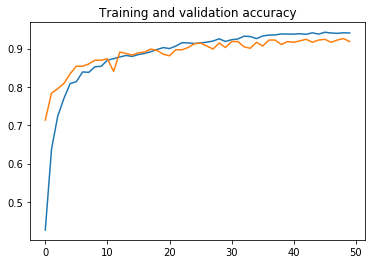

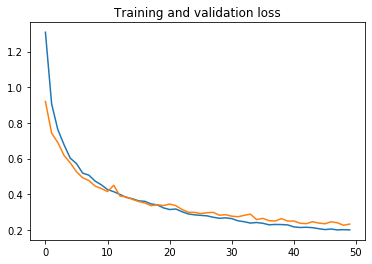

In [0]:
from matplotlib import pyplot

pyplot.plot(history1.history['categorical_accuracy'])
pyplot.plot(history1.history['val_categorical_accuracy'])
pyplot.title('Training and validation accuracy')
pyplot.show()

pyplot.plot(history1.history['loss'])
pyplot.plot(history1.history['val_loss'])
pyplot.title('Training and validation loss')
pyplot.show()

In [0]:
#Confution Matrix and Classification Report
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(np.argmax(y_test, axis =1), y_pred))
print('Classification Report')
#print(classification_report(validation_generator.classes, y_pred, target_names=labels))

Confusion Matrix
[[140   1   2   0]
 [  0 122   6   0]
 [  2  12 110   5]
 [  2   4   8  99]]
Classification Report


In [0]:
617/(617+69+9+91+146+35)

0.6380558428128231

In [0]:
model.load_weights("/content/drive/My Drive/model_vgg19_crop_best_200.h5")

In [0]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from VGG16. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the first convolution blocks, i.e. we will freeze
# the first 15 layers and unfreeze the rest:
for layer in model.layers[:16]: #15
   layer.trainable = False
for layer in model.layers[16:]:
   layer.trainable = True

0 input_3
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_conv4
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_conv4
16 block4_pool
17 block5_conv1
18 block5_conv2
19 block5_conv3
20 block5_conv4
21 block5_pool


In [0]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
#metrics= ['categorical_accuracy']
model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0   

In [0]:
history2=model.fit_generator(    
    datagen.flow(X_train, y_train, batch_size=32),
    steps_per_epoch = len(X_train) // batch_size,
    validation_data = (X_test,y_test), 
    class_weight = 'balanced',
    epochs = 10,callbacks=[tensorboard,checkpointer])

Epoch 1/10
64/64 [==============================] - 8s 121ms/step - loss: 0.4144 - categorical_accuracy: 0.8584 - val_loss: 0.1963 - val_categorical_accuracy: 0.9279

Epoch 00001: val_loss improved from 0.22562 to 0.19626, saving model to /content/drive/My Drive/model_vgg19_crop_best_200.h5
Epoch 2/10
64/64 [==============================] - 7s 116ms/step - loss: 0.1752 - categorical_accuracy: 0.9355 - val_loss: 0.1536 - val_categorical_accuracy: 0.9396

Epoch 00002: val_loss improved from 0.19626 to 0.15358, saving model to /content/drive/My Drive/model_vgg19_crop_best_200.h5
Epoch 3/10
64/64 [==============================] - 7s 116ms/step - loss: 0.1181 - categorical_accuracy: 0.9590 - val_loss: 0.1068 - val_categorical_accuracy: 0.9571

Epoch 00003: val_loss improved from 0.15358 to 0.10684, saving model to /content/drive/My Drive/model_vgg19_crop_best_200.h5
Epoch 4/10
64/64 [==============================] - 7s 116ms/step - loss: 0.0502 - categorical_accuracy: 0.9839 - val_loss: 

In [0]:
#model.save_weights("/content/drive/My Drive/tl-7.h5")

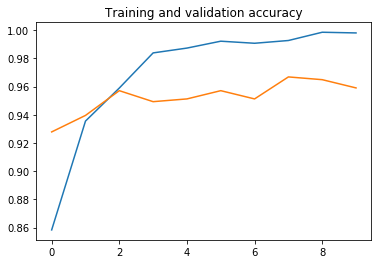

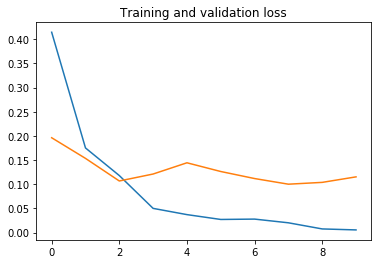

In [0]:
from matplotlib import pyplot

pyplot.plot(history2.history['categorical_accuracy'])
pyplot.plot(history2.history['val_categorical_accuracy'])
pyplot.title('Training and validation accuracy')
pyplot.show()

pyplot.plot(history2.history['loss'])
pyplot.plot(history2.history['val_loss'])
pyplot.title('Training and validation loss')
pyplot.show()

In [0]:
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(np.argmax(y_test, axis =1), y_pred))



Confusion Matrix
[[143   0   0   0]
 [  1 117  10   0]
 [  0   4 120   5]
 [  0   0   1 112]]


In [0]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
#metrics= ['categorical_accuracy']
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0   

In [0]:
history3=model.fit_generator(    
    datagen.flow(X_train, y_train, batch_size=32),
    steps_per_epoch = len(X_train) // batch_size,
    validation_data = (X_test,y_test), 
    class_weight = 'balanced',
    epochs = 10,callbacks=[tensorboard,checkpointer])

Epoch 1/10
64/64 [==============================] - 7s 116ms/step - loss: 0.0025 - categorical_accuracy: 0.9995 - val_loss: 0.0947 - val_categorical_accuracy: 0.9708

Epoch 00001: val_loss did not improve from 0.09318
Epoch 2/10
64/64 [==============================] - 7s 115ms/step - loss: 0.0025 - categorical_accuracy: 0.9995 - val_loss: 0.0935 - val_categorical_accuracy: 0.9747

Epoch 00002: val_loss did not improve from 0.09318
Epoch 3/10
64/64 [==============================] - 7s 116ms/step - loss: 0.0027 - categorical_accuracy: 0.9995 - val_loss: 0.0960 - val_categorical_accuracy: 0.9727

Epoch 00003: val_loss did not improve from 0.09318
Epoch 4/10
64/64 [==============================] - 7s 116ms/step - loss: 0.0032 - categorical_accuracy: 0.9990 - val_loss: 0.0941 - val_categorical_accuracy: 0.9747

Epoch 00004: val_loss did not improve from 0.09318
Epoch 5/10
64/64 [==============================] - 7s 115ms/step - loss: 0.0025 - categorical_accuracy: 0.9995 - val_loss: 0.09

In [0]:
model.load_weights("/content/drive/My Drive/model_vgg19_crop_best_200.h5")

In [0]:
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(np.argmax(y_test, axis =1), y_pred))


Confusion Matrix
[[143   0   0   0]
 [  0 124   4   0]
 [  0   4 122   3]
 [  0   0   3 110]]
